In [370]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import yahoo_finance as yf
import pandas_datareader as pdr
from sklearn.cluster import KMeans
from statsmodels.tsa.api import adfuller
from sklearn.preprocessing import StandardScaler

In [371]:
# Modify some settings
plt.rcParams['figure.figsize'] = (10, 7)
plt.rcParams['font.size'] = 16
plt.rcParams['figure.dpi'] = 150

pd.options.display.max_rows = 20
pd.options.display.max_columns = 15

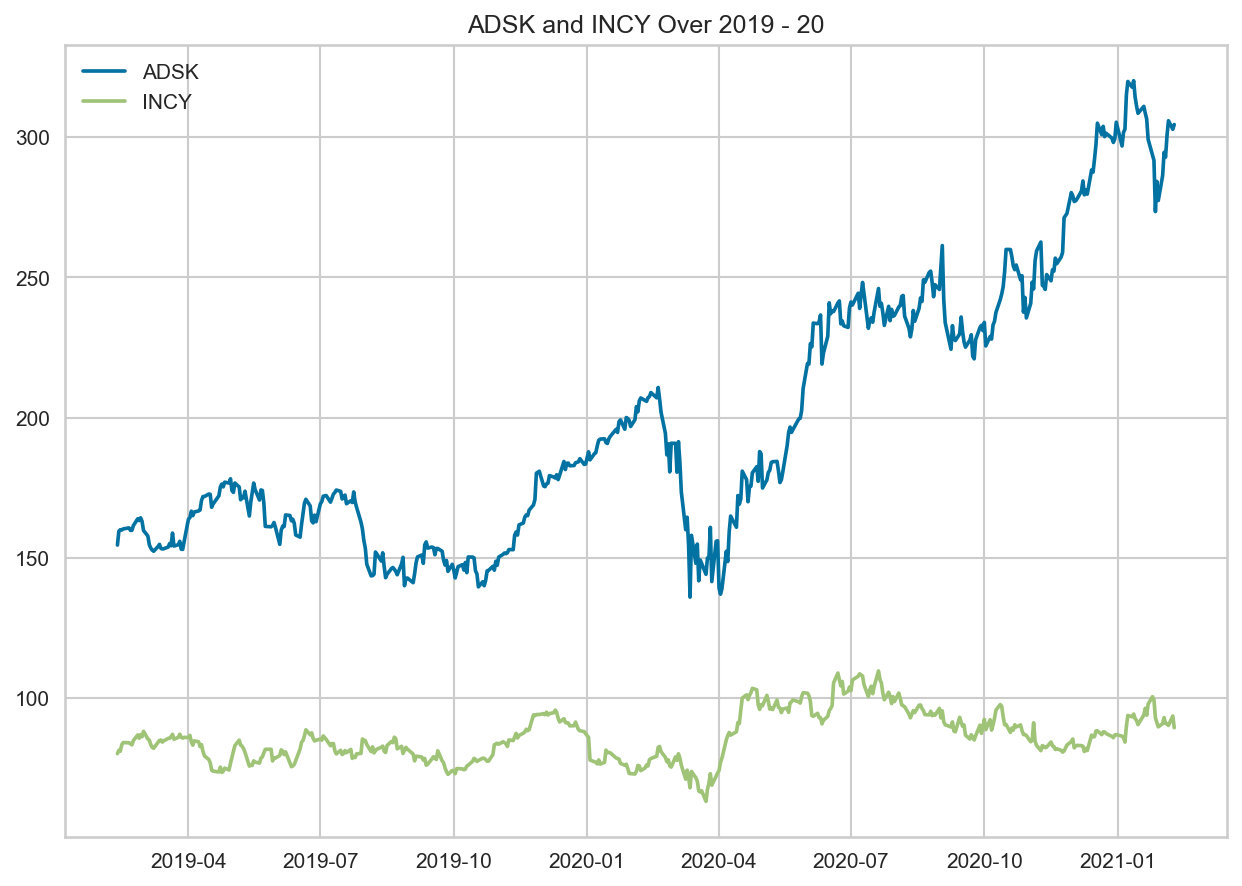

In [372]:
data = pd.read_csv('~/k_means/Data/sp_financials.csv')
data = data.drop(['SEC_Filings', 'Sector', 'Name'], axis=1)
data = data.set_index('Symbol')
data = data.fillna(0)
features = data[['Price', 'Price/Earnings', 'Dividend_Yield', 'Earnings/Share',
       '52_Week_Low', '52_Week_High', 'Market_Cap', 'EBITDA', 'Price/Sales',
       'Price/Book']]

data = StandardScaler().fit_transform(data)

start = '2019-02-09'
end = '2021-02-09'
name_1 = "ADSK"
name_2 = "INCY"
s1 = pdr.get_data_yahoo(name_1, start, end)
s2 = pdr.get_data_yahoo(name_2, start, end)

plt.plot(s1['Close'],label=name_1)
plt.plot(s2['Close'],label=name_2)
plt.title(name_1 + ' and ' + name_2 + ' Over 2019 - 20')
plt.legend(loc=0)
plt.show()

In [373]:
class statarb(object):
    '''
    k-means object with ..... atributes 
    methods
    -------
        create_spread:
        check_cointergration:
        generate_signal:
        generate_returns:
        inputs: 
        attributes:
    -----
    '''
    def __init__(self, df1, df2, s1, s2, ma, floor, ceiling, beta_lookback, start, end, exit_zscore=0):
        self.df1 = df1 # dataframe of stock one
        self.df2 = df2 # dataframe of stock two
        self.s1 = s1 # name of stock one
        self.s2 = s2 # name of stock two        
        self.df = pd.DataFrame(index = df1.index) # new df for data_cleaning method
        self.ma = ma # moving average perio
        self.floor = floor # buy threshold for z-score
        self.ceiling = ceiling # sell threshold for z-score
        self.Close = 'Close Long'
        self.Cover = 'Cover Short'
        self.beta_lookback = beta_lookback # lookback of beta for hedge ratio
        self.start = start # begining of test period
        self.end = end # end of test period
        self.exit_zscore = exit_zscore # z-score
        
    def create_spread(self):
        '''
		parameters
		----------
			self: object: statarb object
		returns
		----------
			self: df: dataframe with chosen stock prices cov, var, beta, hedge ratio and spreads
		'''
        
        # take closing price of chose stocks and add to new dataframe
        self.df[self.s1] = self.df1['Close']
        self.df[self.s2] = self.df2['Close']
        
        # find beta valuse for pair of stocks
        self.df['cov'] = self.df[self.s1].rolling(self.beta_lookback).cov(self.df[self.s2])
        self.df['var'] = self.df[self.s2].rolling(self.beta_lookback).var()
        self.df['beta'] = self.df['cov'] / self.df['var']
        
        # set hedge ratio
        self.df['Hedge Ratio'] = self.df['beta']
        
        self.df['Spread'] = self.df[self.s1] - (self.df['Hedge Ratio']*self.df[self.s2])
        self.df['Spread_2'] = self.df[self.s2] - (self.df['Hedge Ratio']*self.df[self.s1])
        
        return self.df
    
    def check_cointergration(self):
        '''
		parameters
		----------
			self: object: statarb object
		returns
		----------
			string: stated significance level of the chosen stock cointergration
		''' 
        # find coint
        adf = adfuller(self.df['Spread'].dropna())
        # print appropriate response
        if adf[0] < adf[4]['1%']:
            print('Spread is Cointegrated at 1% Significance Level')
        elif adf[0] < adf[4]['5%']:
            print('Spread is Cointegrated at 5% Significance Level')
        elif adf[0] < adf[4]['10%']:
            print('Spread is Cointegrated at 10% Significance Level')
        else:
            print('Spread is not Cointegrated')
        return
    
    def generate_signal(self):
        '''
		parameters
		----------
			self: object: statarb object
		returns
		----------
			self: df: dataframe with 1 or 0 values for long, short, and exit signals, and in position markers
		''' 
        # create stock z score
        self.df['Z_Score'] = ((self.df['Spread'] - self.df['Spread'].rolling(window = self.ma).mean()) / (self.df['Spread'].rolling(window = self.ma).std()))

        # create prior stock z score        
        self.df['Prior_Z_Score'] = self.df['Z_Score'].shift(1)
        
        # use z scores to generate buy, sell, exit signals
        self.df['Long_Signal'] = (self.df['Z_Score'] <= self.floor)*1
        self.df['Short_Signal'] = (self.df['Z_Score'] >= self.ceiling)*1
        self.df['Exit'] = (self.df['Z_Score'] <= self.exit_zscore)*1
        
        # position trackers
        self.df['In_Long'] = 0
        self.df['In_Short'] = 0
        
        # market entry trackers
        self.enter_long = 0
        self.enter_short = 0
        
        # generate signals
        for i, val in enumerate(self.df.iterrows()):
            # long
            if val[1]['Long_Signal'] == 1:
                self.enter_long = 1   
            # short
            if val[1]['Short_Signal'] == 1:
                self.enter_Short = 1   
            # exit
            if val[1]['Exit'] == 1:
                self.enter_Long = 0
                self.enter_Short = 0
            # set status
            self.df.iloc[i]['In_Long'] = self.enter_long
            self.df.iloc[i]['In_Short'] = self.enter_short
            
        return self.df
    
    def generate_returns(self, allocation, pair):
        '''
		parameters
		----------
			self: object: statarb object
            allocation: int: desired dollar value for strategy 
            pair: string: names of two chosen stocks
		returns
		----------
			portfolio: df: dataframe with:  Positions,	
                                            X,
                                            Y,	
                                            Total,	
                                            Returns,	
                                            Win,	
                                            Loss,	
                                            Trade_Returns,	
                                            Portfolio_Value,	
                                            Portfolio_Returns,	
                                            Initial_Value,
		''' 
        self.allocation = allocation
        self.pair = pair
        
        # set up portfolio dataframe
        self.portfolio = pd.DataFrame(index = self.df.index)
        self.portfolio['Positions'] = self.df['Long_Signal'] - self.df['Short_Signal']
        self.portfolio['X'] = -1*self.df[self.s1]*self.portfolio['Positions']
        self.portfolio['Y'] = self.df[self.s2] * self.portfolio['Positions']
        self.portfolio['Total'] = self.portfolio['X'] + self.portfolio['Y']
        
        # create percentage returns stream
        self.portfolio['Returns'] = self.portfolio['Total'].pct_change()
        self.portfolio['Returns'].fillna(0, inplace = True)
        self.portfolio['Returns'].replace([np.inf, -np.inf], 0, inplace = True)
        self.portfolio['Returns'].replace(-1, 0, inplace = True)
        
        # calculate summary statistics
        self.mu = (self.portfolio['Returns'].mean())
        self.sigma = (self.portfolio['Returns'].std())
        self.sharpe = (self.mu - 0.005) / self.sigma
        self.portfolio['Win'] = np.where(self.portfolio['Returns'] > 0, 1, 0)
        self.portfolio['Loss'] = np.where(self.portfolio['Returns'] < 0, 1, 0)
        self.wins = self.portfolio['Win'].sum()
        self.losses = self.portfolio['Loss'].sum()
        self.total_trades = self.wins + self.losses
        
        # win loss ratio
        self.wl_ratio = (self.wins / self.losses)
        
        # probability of win and loss
        self.p_win = (self.wins / self.total_trades)
        self.p_loss = (self.losses / self.total_trades)
        
        # avg win / loss return
        self.avg_win_return = (self.portfolio['Returns'] > 0).mean()
        self.avg_loss_return = (self.portfolio['Returns'] < 0).mean()
        
        # payout ratio
        self.payout_ratio = (self.avg_win_return / self.avg_loss_return)
        
        # getting equity curve
        self.portfolio['Returns'] = (self.portfolio['Returns'] + 1).cumprod()
        self.portfolio['Trade_Returns'] = (self.portfolio['Total'].pct_change())
        self.portfolio['Portfolio_Value'] = (self.allocation * self.portfolio['Returns'])
        self.portfolio['Portfolio_Returns'] = self.portfolio['Portfolio_Value'].pct_change()
        self.portfolio['Initial_Value'] = self.allocation
        
        # plot portfolio valuation
        with plt.style.context(['seaborn-paper']):
            plt.plot(self.portfolio['Portfolio_Value'])
            plt.plot(self.portfolio['Initial_Value'])
            plt.title('Statarb Pair %s Strategy Returns %s to %s' %(self.pair, self.start, self.end))
            plt.legend(loc = 0)
            plt.tight_layout()
            plt.show()
            
        return self.portfolio

In [374]:
# create stat arb object
ilmn_vrsn = statarb(s1, s2, name_1, name_2, 14, -2, 2, 28, start, end)

In [375]:
# find spreads
ilmn_vrsn.create_spread()

,ADSK,INCY,cov,var,beta,Hedge Ratio,Spread,Spread_2
Date,,,,,,,,
2019-02-11,154.570007,80.209999,NaN,NaN,NaN,NaN,NaN,NaN
2019-02-12,159.539993,81.400002,NaN,NaN,NaN,NaN,NaN,NaN
2019-02-13,160.029999,81.059998,NaN,NaN,NaN,NaN,NaN,NaN
2019-02-14,159.940002,83.419998,NaN,NaN,NaN,NaN,NaN,NaN
2019-02-15,160.350006,84.150002,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...
2021-02-03,292.850006,90.970001,2.584401,18.039168,0.143266,0.143266,279.817092,49.014534
2021-02-04,300.489990,90.910004,2.473069,17.617159,0.140378,0.140378,287.728186,48.727687
2021-02-05,305.859985,90.239998,2.292014,17.057776,0.134368,0.134368,293.734642,49.142288


In [376]:
# check cointergration level
ilmn_vrsn.check_cointergration()

Spread is Cointegrated at 1% Significance Level


In [380]:
# generate trade signals 
sig = ilmn_vrsn.generate_signal()
sig

<ipython-input-373-cc0fc3f46d7e>:120: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.df.iloc[i]['In_Long'] = self.enter_long
<ipython-input-373-cc0fc3f46d7e>:121: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.df.iloc[i]['In_Short'] = self.enter_short


,ADSK,INCY,cov,var,beta,Hedge Ratio,Spread,Spread_2,Z_Score,Prior_Z_Score,Long_Signal,Short_Signal,Exit,In_Long,In_Short
Date,,,,,,,,,,,,,,,
2019-02-11,154.570007,80.209999,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,0,0,0
2019-02-12,159.539993,81.400002,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,0,0,0
2019-02-13,160.029999,81.059998,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,0,0,0
2019-02-14,159.940002,83.419998,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,0,0,0
2019-02-15,160.350006,84.150002,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-02-03,292.850006,90.970001,2.584401,18.039168,0.143266,0.143266,279.817092,49.014534,0.981814,1.152520,0,0,0,0,0
2021-02-04,300.489990,90.910004,2.473069,17.617159,0.140378,0.140378,287.728186,48.727687,0.932517,0.981814,0,0,0,0,0
2021-02-05,305.859985,90.239998,2.292014,17.057776,0.134368,0.134368,293.734642,49.142288,0.884595,0.932517,0,0,0,0,0


No handles with labels found to put in legend.


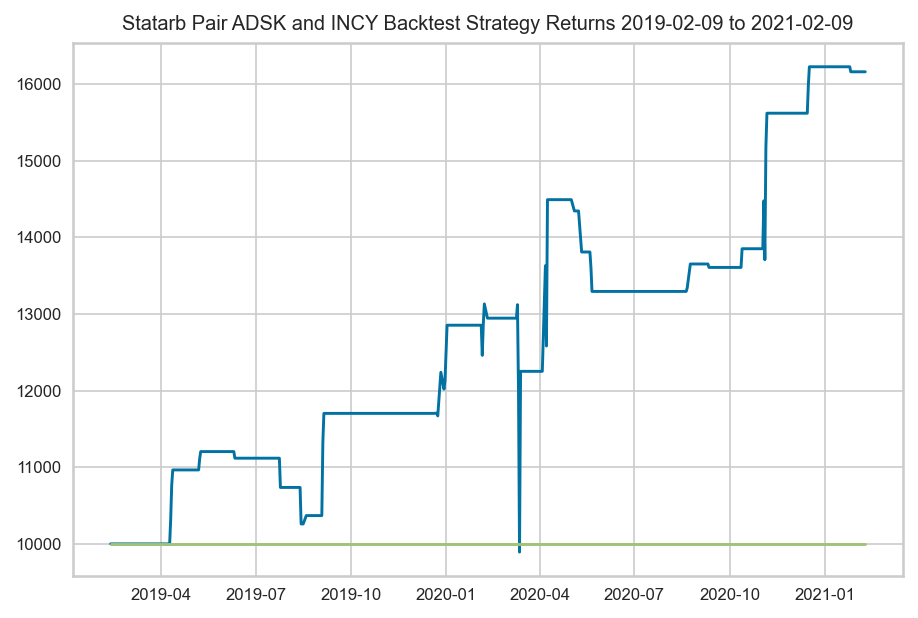

In [381]:
# show portfolio value over trade period
pair = name_1 + " and " + name_2 + " Backtest"
p = ilmn_vrsn.generate_returns(10000, pair)